In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.15.0'

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
X_train.shape,y_train.shape

((60000, 28, 28), (60000,))

In [5]:
X_train[0].shape

(28, 28)

5


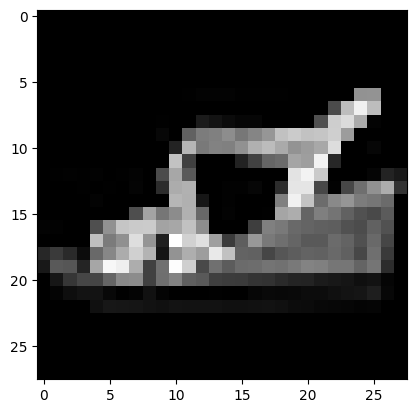

In [9]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i] , cmap = 'gray');

In [10]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [11]:
X_train.shape

(60000, 28, 28, 1)

In [12]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [13]:
X_train = (X_train - 127.5) / 127.5

In [15]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [16]:
buffer_size = 60000
batch_size = 256

In [17]:
X_train=tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [18]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [19]:
def build_generator():
  network=tf.keras.Sequential()

  network.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,))) #100 random numbers at first
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU()) #recommended for GANs

  network.add(layers.Reshape((7, 7, 256))) # converting to matrix

  #7*7*128
  network.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  #Conv2D transpose upsamples the feature map when a big stride is applied instead of downsampling it
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  #14*14*64
  network.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())


  network.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

  network.summary()

  return network


In [20]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [21]:
def build_discriminator():
  network = tf.keras.Sequential()
  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 6272
  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [22]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

### In simple terms, logits are the raw, unnormalized predictions generated by a model before applying any activation function. They represent the linear output of a model before it is transformed into probabilities

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [26]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001

## Training the model

In [39]:
epochs = 200
noise_dim = 100
num_images_to_generate = 16

In [29]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In TensorFlow, the @tf.function decorator is used to convert a Python function into a TensorFlow graph, which can provide significant performance benefits. By doing this, TensorFlow can optimize the operations, run them efficiently on various hardware (like GPUs and TPUs), and utilize features like auto-differentiation.

In [38]:
# bs = 32
# nd = 100

# # Generate random noise
# noise = tf.random.normal([bs, nd])

# # Print the shape and a sample of the generated noise
# print("Shape of noise tensor:", noise.shape)
# print("Sample noise vector:\n", noise.numpy()[0])

In TensorFlow, tf.GradientTape is used for automatic differentiation, which is crucial for training machine learning models

In [32]:
generated_image = generator(noise, training = False)

In [33]:
generated_image.shape

TensorShape([32, 28, 28, 1])

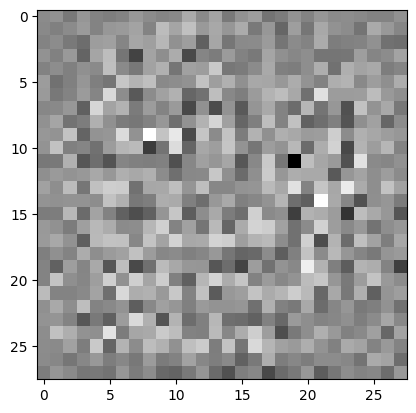

In [36]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');

In [37]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  #zip pairs each gradient with the corresponding variable.

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [40]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_steps(image_batch)
    if(epoch%20):
      print('Epoch: ', epoch + 1)
      predictions = generator(test_images, training = False)
      fig = plt.figure(figsize=(10,10))
      for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1) #total 16
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') #denormalize to show
        plt.axis('off')
      plt.show()

In [41]:
train(X_train, epochs, test_images)

Output hidden; open in https://colab.research.google.com to view.